# Activity Tracker
## Introduction
In the past decade, there has been increased interest on fitness and health. People started to look for ways to be able to track their progress and their status. A suitable and easy to access methods to measure these statuses started to emerge as a good and practical idea instead of always having to go to a specialist to do it.
Hence, the fitness trackers was developed. They use different sensors to measure different variables and using an appropriate algorithm they detect the activity and give the corresponding feedback.

## Methodology

### Problem definition and Database Overview
This project is going to implement a small version of developing such an algorithm using deep learning. This is going to be done using a public database that contains the data of 30 subjects. These data includes for each axis in the physical three dimensions (x, y, z), a recording for the values: gravitational acceleration, body acceleration, and body gyroscope. So, this dataset has a total of 9 features. They were recorded using the embedded accelerometer and gyroscope sensors in a Samsung Galaxy SII phone. The data were then sampled in a timesteps manner so as for each sample there are 128 readings for a total of 10299 samples. So, the shape of the dataset is 10299 sample, each has 128 timestep, each has 9 features readings. The data was already preprocessed to reduce the noise and has been normalized so the fall in the range of [-1, 1]. These records were recorded during different activities which are: three static postures (standing, sitting, lying), and three dynamic activities (walking, walking downstairs and walking upstairs). Each sample corresponds to one of the previous 6 activities. So, the problem is a single label multiclass classification.(1)(2)(3) 


### Dataset Loading
This dataset was meant to be analysed using support vector machine (SVM) kernel method. So, they were feature engineered and preseparated into training and test sets. But as for this project we are going to use deep learning we are going to use the data that are in the "Inertial Signals" folder, which has not been feature engineered and then combine the training and test sets together to allow for more extensive learning and more flexibility in applying deep learning. We are going to use the provided loading code as a base and modify it accordingly.(3)

In [31]:
# load dataset
import pandas as pd
import numpy as np

# load a single file as a numpy array
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load all train
trainX, trainy = load_dataset('train', 'UCI HAR Dataset/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', 'UCI HAR Dataset/')
print(testX.shape, testy.shape)

# combine all train and test data
dataX = np.append(trainX, testX, axis=0)
datay = np.append(trainy, testy, axis=0)
print(dataX.shape, datay.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(10299, 128, 9) (10299, 1)


The results above confirms that we have 10299 samples, each with 128 timestep, with 9 features readings each, and a corresponding same length two dimensions labels dataset.

### Data Check and Visualization
Before starting to train the data, we are going to look into it to make sure we correctly loaded the data, and it is as we understand. 
So, first as we know that all subjects performed the same activities, the total number of each activity should be almost equal and thus the data for the activity should be somewhat balanced when compared to the total number of activities performed. We are going to use the provided code as a base and modify it accordingly.(3)

Both
[1722 1544 1406 1777 1906 1944]
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


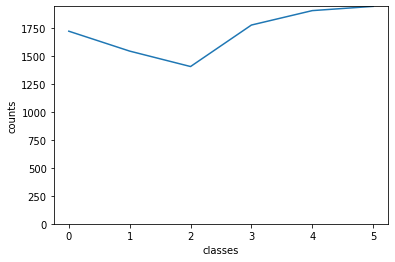

In [20]:
# summarize class balance
import matplotlib.pyplot as plt

# summarize the balance of classes in an output variable column
def class_breakdown(data):
	# convert the numpy array into a dataframe
	df = pd.DataFrame(data)
	# group data by the class value and calculate the number of rows
	counts = df.groupby(0).size()
	# retrieve raw rows
	counts = counts.values
	# summarize
	for i in range(len(counts)):
		percent = counts[i] / len(df) * 100
		print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))
	
	fig = plt.subplot(xlabel="classes", ylabel="counts")
	fig.plot(range(len(counts)), counts)
	fig.set(ylim=(0, np.amax(counts)))

	plt.show()

 
# summarize class breakdown
class_breakdown(datay)

The results confirms that all classes have similar frequency among the dataset.

Secondly, we are going to look at the activity of a random subject and visualize it to make sure it is corresponding with the dataset description. As they mentioned that the windows has 50% overlap, we are going to filter those to have unique windows only with no repetitions of activities and thus allowing us to visualize the data more easily. This is done by only taking the second half of the data in each window by implementing the function "to_series". Then for each activity feature for the randomly chosen subject a seperated plot is created, presenting the data of that feature during the modified windows. The plots are then stacked on top of each other to be compared. The plots should view appropriate behaviour patterns during different timeframes that are consistent with the activity of that window. Again, We are going to use the provided code as a base and modify it accordingly.(3)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(344, 128, 9) (344, 1)


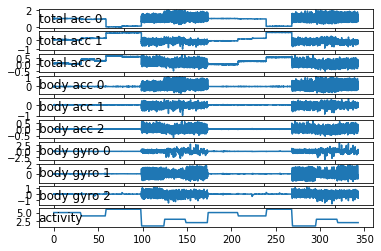

In [29]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series
 
# plot the data for one subject
def plot_subject(X, y):
	plt.figure()
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		plt.subplot(n, 1, off+1)
		plt.plot(to_series(X[:, :, off]))
		plt.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		plt.subplot(n, 1, off+1)
		plt.plot(to_series(X[:, :, off]))
		plt.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		plt.subplot(n, 1, off+1)
		plt.plot(to_series(X[:, :, off]))
		plt.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	plt.subplot(n, 1, n)
	plt.plot(y)
	plt.title('activity', y=0, loc='left')
	plt.show()
 
# load mapping of rows to subjects
sub_map = load_file('UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
# get the data for one subject
sub_id = np.random.choice(train_subjects)
subX, suby = data_for_subject(dataX, datay, sub_map, sub_id)
# plot data for subject
plot_subject(subX, suby)

These results shows activity patterns for the different feartures that are consistent with specific windows and thus specific activities, which confirms our understanding of the data.

### Data Preprocessing
As the data has been already preprocessed, we are not going to do much. 
We are going to one-hot encode the labels after converting it to a one dimensional dataset, and split the data into training and test sets.

In [59]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

datay_1D = np.reshape(datay, datay.shape[0])
dataX_flat = dataX.reshape((dataX.shape[0], dataX.shape[1]*dataX.shape[2]))
one_hot_datay = to_categorical(datay_1D)
print(one_hot_datay.shape)
X_train, X_test, y_train, y_test = train_test_split(dataX_flat, one_hot_datay, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10299, 7)
(8239, 1152)
(2060, 1152)
(8239, 7)
(2060, 7)


### Data Training
Now as we have our data ready, we are going to start by building the network, as we are going to try to tune our hyperparameters and network capacity, we are going to implement building the network in a function so we can use it multiple time while changing the variables.
The are some constants we are going to use, as this is a single label multi class problem with three dimensional input data, a three layers network seems sufficient, with softmax activation function in the final layer, rmsprop as optimizer, categorical_crossentropy as loss function, accuracy as evaluation metric.

In [80]:
from random import randint
from sklearn import metrics
from tensorflow.keras import models
from tensorflow.keras import layers

def build(layer_1, layer_2, layer_3, inp_shape):
    model = models.Sequential()
    model.add(layers.Dense(layer_1, activation = 'relu', input_shape = (inp_shape[1],)))
    model.add(layers.Dense(layer_2, activation = 'relu'))
    model.add(layers.Dense(layer_3, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

def train(model, X, y, ep = 5, b_size = 512, val_data = None, verb = 'auto'):
    return model.fit(X, y, epochs = ep, batch_size = b_size, validation_data = val_data, verbose = verb)


Now, we created functions to create a basic model and train the data using 5 epochs, and batch size of 512 which were randomly selected.
We are going to test these parameters on the dataset. 

In [81]:
model = build(layer_1=256, layer_2=64, layer_3=7, inp_shape=X_train.shape)
history = train(model, X_train, y_train)
print(model.evaluate(X_test, y_test))
idx_rnd = randint(0, len(X_test)-1)
print(np.argmax(model.predict(X_test)[idx_rnd]))
print(np.argmax(y_test[idx_rnd]))

Epoch 1/5
17/17 [==============================] - 1s 6ms/step - loss: 0.9485 - accuracy: 0.6439
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.4371 - accuracy: 0.8620
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.3021 - accuracy: 0.9008
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.2296 - accuracy: 0.9232
Epoch 5/5
65/65 [==============================] - 0s 1ms/step - loss: 0.2057 - accuracy: 0.9277
[0.20568019151687622, 0.927669882774353]
65/65 [==============================] - 0s 1ms/step
5
5


As we can see, the current settings of the model are doing pretty well, as the accuracy score in both the training data and the test data are almost the same, which decreases the likelihood that overfitting occured on the training data

To improve the model further, we are going to apply multiple tests on the model.
First, we are going to try different sizes for the network layers

In [131]:
scores_total = np.zeros((4,4))
headers = []
for k in range(5):
    scores = np.zeros((4,4))
    for i in range(4):
        for j in range(0, 4-i):
            units1 = 2**(6+i+j)
            units2 = 2**(6+i)
            if k==0: headers.append(units1)
            model = build(layer_1=units1, layer_2=units2, layer_3=7, inp_shape=X_train.shape)
            history = train(model, X_train, y_train, verb=0)
            scores[j+i][i]=model.evaluate(X_test, y_test, verbose=0)[1] / history.history['accuracy'][-1]
    if k==0: scores_total=scores 
    else: scores_total = np.mean([scores_total, scores], axis=0)
headers = np.unique(headers)
headers = headers.astype(str)
print('The mean ratio of the accuracy score of the test set to the training set:')
print(pd.DataFrame(scores_total, ['layer1 '+h for h in headers], ['layer2 '+h for h in headers]))
print(' ')

The mean ratio of the accuracy score of the test set to the training set:
            layer2 64  layer2 128  layer2 256  layer2 512
layer1 64    0.974008    0.000000    0.000000    0.000000
layer1 128   0.959909    0.958806    0.000000    0.000000
layer1 256   0.964231    0.978824    0.975071    0.000000
layer1 512   0.988038    0.989746    0.984799    0.989423
 


Testing the model with different network sizes, and running the tests multiple times and comparing th accuracy scores of the test sets to the training sets shows us that they were almost equal, with the best similarity while layer1 size is 512 units and layer2 is 128 units, which maybe just a random incidence but as all the sizes are performing good w are going to use these sizes as a base for our model

#### Data Validation
Now, we are going to figure the best epoch to avoid overfitting while guranteeing good learning of the data. We are going to do by performing. And as the data is a bit small we are going to use k-fold validation instead of hold-ut validation.

In [ ]:
def plot_epochs(x, y_A, style_A, label_A, y_B, style_B, label_B, title, x_label, y_label):
    plt.clf()
    plt.plot(y_A, style_A, label = label_A)
    plt.plot(y_B, style_B, label = label_B)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()



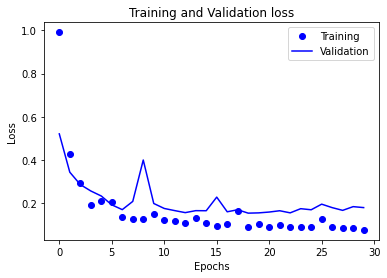

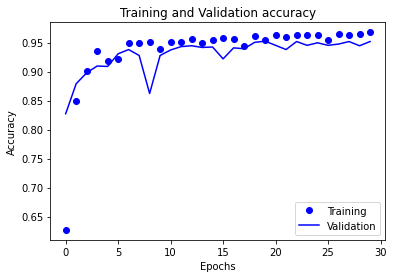

18 epochs


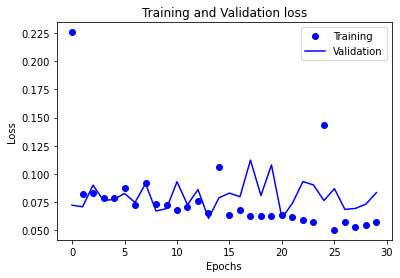

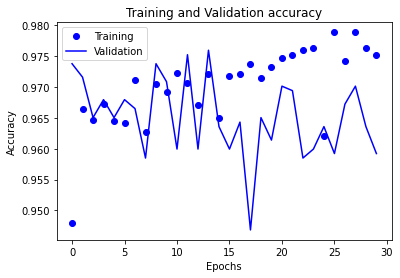

13 epochs


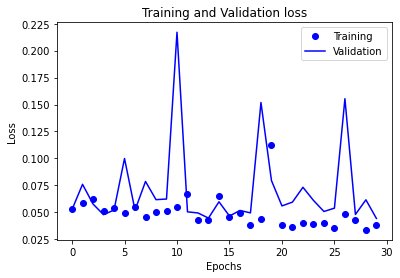

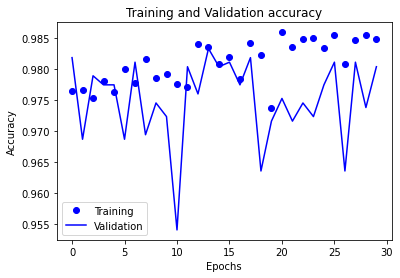

29 epochs


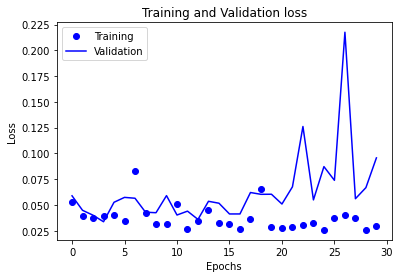

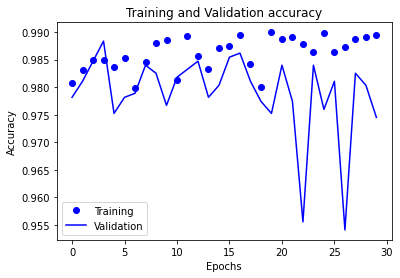

3 epochs


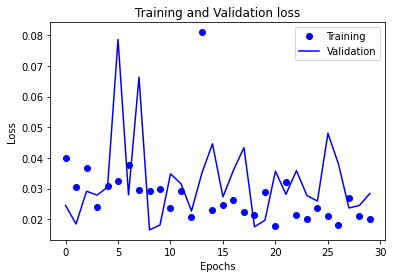

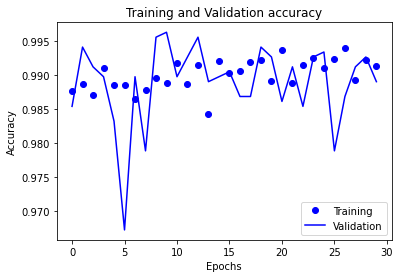

8 epochs


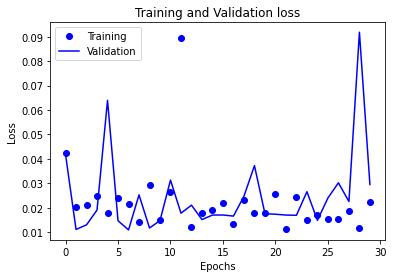

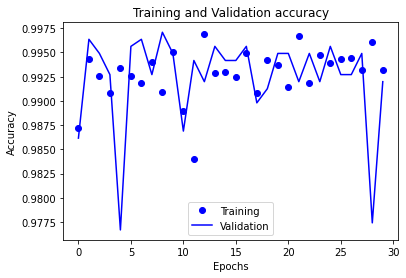

6 epochs


In [167]:
model = build(layer_1=512, layer_2=128, layer_3=7, inp_shape=X_train.shape)


k=6
num_samples_X = int(len(X_train)/k)
num_samples_y = int(len(y_train)/k)

loss = []
val_loss = []
acc = []
val_acc = []

for fold in range(k):
    # aX, bX mark partition end points for X training set
    aX, bX = num_samples_X * fold, num_samples_X * (fold+1)
    # ay, by mark partition end points for y training set
    ay, by = num_samples_y * fold, num_samples_y * (fold+1)
    # validation X dataset partition
    val_data_X = X_train[aX:bX]
    # validation y dataset partition
    val_data_y = y_train[ay:by]
    # concatenate remaining partitions
    partial_X = np.concatenate((X_train[:aX], X_train[bX:]))
    partial_y = np.concatenate((y_train[:ay], y_train[by:]))

    history = train(model, partial_X, partial_y, ep = 30, val_data = (val_data_X, val_data_y), verb = 0)

    plot_epochs(range(1, len(loss)+1), history.history['loss'], 'bo', 'Training', history.history['val_loss'], 'b', 'Validation', 'Training and Validation loss', 'Epochs', 'Loss')
    plot_epochs(range(1, len(acc)+1), history.history['accuracy'], 'bo', 'Training', history.history['val_accuracy'], 'b', 'Validation', 'Training and Validation accuracy', 'Epochs', 'Accuracy')
    print(np.argmin(history.history['val_loss']), 'epochs')

    loss = history.history['loss'] if fold==0 else np.mean([loss, history.history['loss']], axis=0)
    val_loss = history.history['val_loss'] if fold==0 else np.mean([val_loss, history.history['val_loss']], axis=0)
    acc = history.history['accuracy'] if fold==0 else np.mean([acc, history.history['accuracy']], axis=0)
    val_acc = history.history['val_accuracy'] if fold==0 else np.mean([val_acc, history.history['val_accuracy']], axis=0)


So, now that we have the average scores of the validation tests we are going to plot them, to look for the epoch with the lowest loss in both the training and the valdiation data

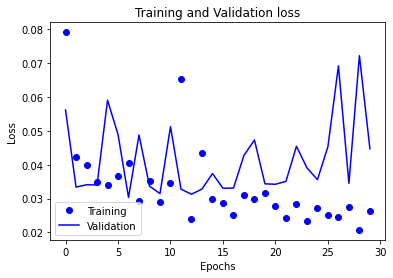

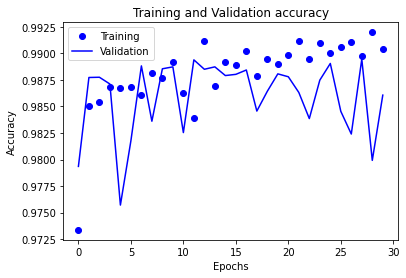

6 epochs


In [168]:
plot_epochs(range(1, len(loss)+1), loss, 'bo', 'Training', val_loss, 'b', 'Validation', 'Training and Validation loss', 'Epochs', 'Loss')
plot_epochs(range(1, len(acc)+1), acc, 'bo', 'Training', val_acc, 'b', 'Validation', 'Training and Validation accuracy', 'Epochs', 'Accuracy')
print(np.argmin(val_loss), 'epochs')

The tests show that 6 epochs are suitable to train the data while avoiding overfitting.
Finally, we are going to try combined L1 and L2 regularization and check i regularization provides better fitting of the data 

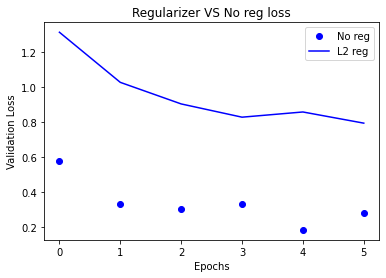

In [173]:
from tensorflow.keras import regularizers
model = build(layer_1=512, layer_2=128, layer_3=7, inp_shape=X_train.shape)
history = train(model, partial_X, partial_y, ep = 6, val_data = (val_data_X, val_data_y), verb = 0)

l2_model = models.Sequential()
l2_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation = 'relu', input_shape = (X_train.shape[1],)))
l2_model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
l2_model.add(layers.Dense(7, activation = 'softmax'))
l2_model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
l2_history = train(l2_model, partial_X, partial_y, ep = 6, val_data = (val_data_X, val_data_y), verb = 0)

plot_epochs(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], 'bo', 'No reg', l2_history.history['val_loss'], 'b', 'L2 reg', 'Regularizer VS No reg loss', 'Epochs', 'Validation Loss')


The results show that the model performs better without regularization, so we will not use it.
So now we are going to train the whole training set with the parameters we have chosen.

In [187]:
model = build(layer_1=512, layer_2=128, layer_3=7, inp_shape=X_train.shape)
history = train(model, X_train, y_train, ep = 6)

Epoch 1/6
17/17 [==============================] - 1s 11ms/step - loss: 0.9646 - accuracy: 0.6514
Epoch 2/6
17/17 [==============================] - 0s 11ms/step - loss: 0.3741 - accuracy: 0.8814
Epoch 3/6
17/17 [==============================] - 0s 10ms/step - loss: 0.2720 - accuracy: 0.9044
Epoch 4/6
17/17 [==============================] - 0s 11ms/step - loss: 0.1994 - accuracy: 0.9300
Epoch 5/6
17/17 [==============================] - 0s 11ms/step - loss: 0.1806 - accuracy: 0.9331
Epoch 6/6
17/17 [==============================] - 0s 11ms/step - loss: 0.1372 - accuracy: 0.9462


#### Data Evaluation
We are now going to evaluate the model on the test set

In [199]:
print('The training set loss is ', history.history['loss'][-1], ' and accuracy score is ', history.history['accuracy'][-1])
[loss, acc] = model.evaluate(X_test, y_test, verbose=0)
print('The test set loss is ', loss, ' and accuracy score is ', acc)

activities = load_file("UCI HAR Dataset/activity_labels.txt")
activities = {act[0]:act[1] for act in activities}
print(activities)
idx_rnd = randint(0, len(X_test)-1)
predict = np.argmax(model.predict(X_test, verbose=0)[idx_rnd])
true_label = np.argmax(y_test[idx_rnd])
print('Model prediction of a random sample ', predict, ' (',activities[predict],')')
print('True label of the sample ', true_label, ' (',activities[true_label],')')

The training set loss is  0.13718779385089874  and accuracy score is  0.9462313652038574
The test set loss is  0.19172748923301697  and accuracy score is  0.9291262030601501
{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
Model prediction of a random sample  4  ( SITTING )
True label of the sample  4  ( SITTING )


## Results
The final model gives an acuracy score of 0.9291262030601501 on the test set, which is pretty close to the accuuracy score of the training set 0.9462313652038574.

## Conclusion
The model works very well in predicting the activity with accuracy =~ 0.93 which is way better than the baseline prediction 1/6= 0.17. So, the model is pretty reliable.
There can be a better way to tune up the parameters as they were giving different results each time they were running but we are satisfied with the current settings and results.

## References

1) Anguita, D., Ghio, A., Oneto, L., Parra, X., Reyes-Ortiz, J.L., 2012. Human Activity Recognition on Smartphones Using a Multiclass Hardware-Friendly Support Vector Machine, in: Lecture Notes in Computer Science. Lecture Notes in Computer Science, pp. 216–223.. doi:10.1007/978-3-642-35395-6_30
2) Jorge-L. Reyes-Ortiz, Luca Oneto, Albert SamÃ , Xavier Parra, Davide Anguita. Transition-Aware Human Activity Recognition Using Smartphones. Neurocomputing. Springer 2015.
3) Brownlee, J. (September 17, 2018). "How to Model Human Activity From Smartphone Data." Retrieved August 29, 2022, from https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/